# Building a Student Intervention System

Project developed for Udacity's Machine learning nano degree. For more information check out their [website](www.udacity.com).

As education has grown to rely more on technology, vast amounts of data has become available for examination and prediction. Logs of student activities, grades, interactions with teachers and fellow students, and more, are now captured in real time through learning management systems like Canvas and Edmodo. This is especially true for online classrooms, which are becoming popular even at the primary and secondary school level. Within all levels of education, there exists a push to help increase the likelihood of student success, without watering down the education or engaging in behaviors that fail to improve the underlying issues. Graduation rates are often the criteria of choice, and educators seek new ways to predict the success and failure of students early enough to stage effective interventions.

A local school district has a goal to reach a 95% graduation rate by the end of the decade by identifying students who need intervention before they drop out of school. As a software engineer contacted by the school district, our task is to model the factors that predict how likely a student is to pass their high school final exam, by constructing an intervention system that leverages supervised learning techniques. The board of supervisors has asked that you find the most effective model that uses the least amount of computation costs to save on the budget. 

The dataset will be analyzed to predict the likelihood that a given student will pass, quantifying whether an intervention is necessary.


## Classification vs. Regression
The question posed in this problem is: does the particular student in question need intervention. Since the answer to this question is a simple, yes or no, the problem is a classification problem. I.e, we need to classify each student and a "yes" label or a "no" label.

# Exploring the Data
The code below imports our libraries and our data.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline
plt.style.use('ggplot')

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

# Define a random state to seed your algorithms
ran_state = 42

Student data read successfully!


## Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the In the code cell below, we compute some basic statistics:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [8]:
def disp_student_stats():
    
    n_students = len(student_data.index)
    n_features = len(student_data.columns)-1
    n_passed = len(student_data[student_data['passed']=='yes'])
    n_failed = len(student_data[student_data['passed'] == 'no'])
    grad_rate = float(n_passed)/float(n_failed + n_passed)

    # Print the results
    print "Total number of students: {}".format(n_students)
    print "Number of features: {}".format(n_features)
    print "Number of students who passed: {}".format(n_passed)
    print "Number of students who failed: {}".format(n_failed)
    print "Graduation rate of the class: {:.2f}%".format(grad_rate*100)

disp_student_stats()

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


# Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

## Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Lets see how many features are numeric and non-numeric.

In [4]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head(1)

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob     Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home  teacher   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   

  absences  
0        6  

[1 rows x 30 columns]


## Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [9]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        #If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output
prev_length = len(X_all.columns)
X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))
print "Total dummy features added = {}".format((len(X_all.columns)-prev_length))


Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Total dummy features added = 0


## Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets.

In [12]:
from sklearn.model_selection import train_test_split

# Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all, test_size=num_test, random_state=42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])


Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In the following section, we will evaluate the performance of different models. First the potential models will be discussed, then tested.

The following algorithms were investigated:

- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbours (Neighbours)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

Information on each algorithm can be found at [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html). 

Taking this documentation into consideration, the following three algorithms have been selected to be investigated, for reasons listed below:

__Gaussian Naive Bayes (GaussianNB)__: The Gaussian Naive Bayes algorithm applies Bayes’ theorem to calculate posterior probability of a class with the “naive” assumption of independence between every pair of features. The probability distribution is assumed to be Gaussian.

* _Real World Application_: Gaussian Naive Bayes is used frequently for text classification, for example determining if an email is spam or not (1)
* _Strengths of Model_: GaussianNB is a fast algorithm used to quickly establish a baseline for a classifier. It has a training complexity of O(nd+cd), where d is the number of dimensions and n is the number of instances. It also has the advantage of being able to dynamically update itself using the `partial_fit` method. It is a high bias, low variance model, and would thus work well with a smaller dataset.
* _Weaknesses of Model_: Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features. Upon examining the data, it can be assumed that features of the data may not follow this rule. For example, absences from school could be explained from a poor health rating (i.e the features of `absences` and `health` are not independent).
* _Selection Justification_: The ability to self-update itself makes it worth it to investigate this algorithm. If the system is scaled up to millions of students, it may be impractical to have to train the system every time a new data point in entered. If the algorithm can work well enough, it would make for a very functional, fast and accurate system, as compared to other algorithms, such as a decision tree, which does not support online learning. GaussianNB should also work well with our low amount of data.

__Random Forest__: A Random Forest is a ensembling algorithm that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. It does not implement boosting on the trees, and instead counts a vote of each individual tree in order to produce the final class label.
* _Real World Application_: Random Forest has been used in Diabetic Retinopathy classification analyses (3), and is very popular for Kaggle competitions.
* _Strengths of Model_: The strength of the Random Forest classifier comes from the formation of it's trees. Because it is formed from "random" subsets of the data, and the final result is compared to other trees that have also been formed "randomly", the algorithm guards well against "overfitting" from noisy data points that may have more influence on a single decision tree algorithm. The "random" formation of the trees ensures that there is little chance for a strong bias to be present in the data during tree construction. (2) Random Forests also work well with high dimensional data (3).
* _Weaknesses of Model_: A lot of trees are necessary to get stable estimates of variable importance and proximity. This can lead to a large amount of space in memory being needed to store the trees. Additionally, the trees need to be re-trained when new data is being introduced, unlike Naive Bayes. Its training complexity is given as O(M √d n log n) where d is the number of features and M is the number of trees. 
* _Selection Justification_: Since random forest works well with high dimensional data, as is competitive with other algorithms such as SVM without the high training cost (3) it is selected for our study.

__Adaboost__: AdaBoost or "adaptive boosting" begins by fitting a "weak" classifier on the original dataset. It then fits additional copies of the classifier on the same dataset and adjusts the weights of incorrectly classified instances such that subsequent classifiers focus more on difficult cases. The adjustment is done using the SAMME-R algorithm (for classification)
* _Real World Application_: Adaboost has been used in robust real time face detection (4). It is also quite popular for Kaggle competitions.
* _Strengths of Model_: Because of it's boosting property, Adaboost will not suffer from overfitting caused by too many training periods in the boosting algorithm. Theoretically, the algorithm should produce better and better results the more it is trained.
* _Weaknesses of Model_: Adaboost is slow to train, relative to GaussianNB (actual training complexity could not be found). 
* _Selection Justification_: It will be interesting to measure the performance of the boosting method of Adaboost vs the vote method for the RF algorithm, as both use decision trees and differ only in the method in which the tree are ensembled together for the final classification.

## Setup
The code below initializes some helper functions used to test the models later.

In [13]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test))
    
def clf_test_f1_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test.values, y_pred, pos_label='yes')
    

## Implementation: Model Performance Metrics
We will now test our classifiers using the functions above. All of the classifiers from sklearn will be tested, but only the ones discussed will have the results recorded.

In [15]:
# TODO: Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = ran_state), 
            RandomForestClassifier(random_state = ran_state), 
            SVC(random_state = 42), LogisticRegression(random_state = ran_state),
            DecisionTreeClassifier(random_state = ran_state),
            KNeighborsClassifier()]

# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [X_train[0:100],X_train[0:200],X_train]
train_target_list = [y_train[0:100], y_train[0:200], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list[0:3]:
    for X_train, y_train in zip(train_feature_list, train_target_list):
        train_predict(clf, X_train, y_train, X_test, y_test)
        

        

Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0028 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 0.8467.
Made predictions in 0.0005 seconds.
F1 score for test set: 0.8029.

Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0015 seconds
Made predictions in 0.0007 seconds.
F1 score for training set: 0.8406.
Made predictions in 0.0006 seconds.
F1 score for test set: 0.7244.

Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0017 seconds
Made predictions in 0.0008 seconds.
F1 score for training set: 0.8038.
Made predictions in 0.0006 seconds.
F1 score for test set: 0.7634.

Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.2288 seconds
Made predictions in 0.0136 seconds.
F1 score for training set: 0.9481.
Made predictions in 0.0089 seconds.
F1 score for test set: 0.7669.

Training a AdaBoostClassifier using a training set size of 200. . .


### Tabular Results

** Classifer 1 - GaussianNB**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0022             |        0.0009         |      0.8467      |     0.8029      |
| 200               |     0.0021              |         0.0010        |      0.8406      |     0.7244      |
| 300               |     0.0024              |         0.0010         |    0.8038       |    0.7634     |

** Classifer 2 - AdaBoostClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.2544              |        0.0149         |      0.9481      |     0.7669      |
| 200               |     0.2602              |         0.0102        |      0.8927      |     0.8281      |
| 300               |     0.2616              |         0.0286         |     0.8637       |    0.7820     |

** Classifer 3 - RandomForestClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |       0.0647            |      0.0206            |    0.9844        |     0.7153      |
| 200               |       0.0819            |      0.0117            |    0.9964        |     0.7857      |
| 300               |       0.0605            |      0.0140            |    0.9951        |     0.8092      |

## Classifier Visualization
In order to make sure we are covering all of the bases, a visualization was created showing the out of box performance for all of the classifiers mentioned in the Model Application Section.

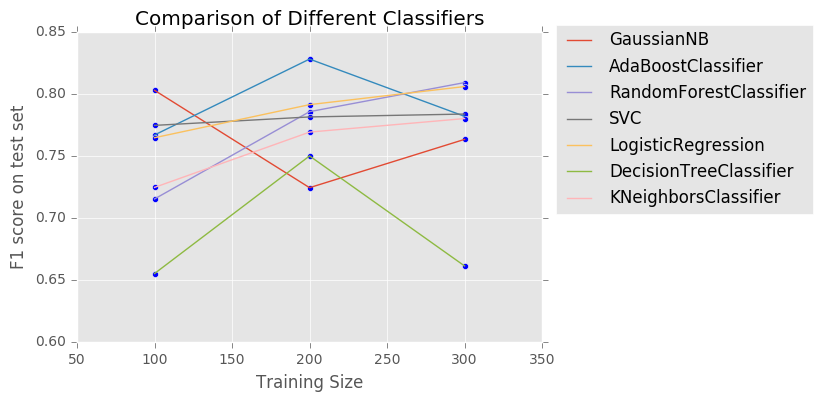

In [16]:
#Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for X_train, y_train in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_f1_score(clf, X_train, y_train, X_test, y_test))
        x_graph.append(len(X_train))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('F1 score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=(13,9))             
plt.show()




As expected, the Adaboost Classifier performs very well. In this case, for a training size of 200, it returns the highest F1 score for the test data. The second place contender is Random Forest with the highest F1 score for a training size of 300. 

# Choosing the Best Model 

Based on the experiments performed, Adaboost is selected as the 'best' model for the experiment. In making this decision, the following points have been considered:

* __Performace__: Comparing Adaboost to the rest of classifiers, it has the largest F1 score based on the test data. Notably, it achieves it's highest score with a test size of 200 instead of 300. This is really the highest priority for our student intervention system, as we want to be able to intersect as many students in need as possible. 

* __Available Data__: Adaboost does not seem to suffer from a problem from available data. It's performace actually seems to get worse as more data is added. This could be considered a plus, as more data might be hard to obtain.

* __Computational Cost__: In training, Adaboost has the worst training time by a factor of roughly 10. Normally, this would be very undesirable for an algorithm; however, in this case, the training time is only ~0.2s and does not seem to scale significantly as more data points are added. It may be the case that in a system used countrywide, Adaboost may only need to be trained on a small set of data. The larger problem would be prediction time if the system is being queried multiple times by other databases. However, the prediction time for Adaboost is linearly competitive with the Random Forest algorithm.



## Implementation: Model Tuning
We will use grid search (`GridSearchCV`) to tune the object.

Using Stratified Shuffle Split:

* As mentioned in the section about dataset exploring the data, the dataset is unbalanced.
* To better model unbalanced data, it’s always preferable to use a stratified shuffle split. This is because using Stratified shuffle split, the dataset is split so as to preserve the percentage of samples for each class.
* This method avoids not having a single representative of the minor class in a fold.
* Also, given a small data with highly unbalanced classes, stratification provides a safeguard and more consistency among the classes in the two splits.
* The main advantage of this procedure is that it reduces experimental variance, which makes it easier to identify the best methods under consideration (hyper-parameters)

In [18]:
# Import StratifiedShuffleSplit from sklearn
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Define your classifier to optimise. You can choose to optimise classifiers
# other than adaboost.
clf = AdaBoostClassifier(random_state=ran_state)

# Create the parameters list you wish to tune
parameters = {'n_estimators' : [30, 50, 70, 80],
              #'algorithm'    : ['SAMME', 'SAMME.R'],
              'learning_rate': [0.001, 0.01, .80, 1.0]}

# Create the Stratified Shuffle Split object
sss = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.24, random_state=ran_state)

# Make an f1 scoring function using 'make_scorer'
f1_scorer = make_scorer(f1_score, pos_label="yes")

# Create a grid search object, and use the sss object in place of cv parameter
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer,
                       cv=sss)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Print the parameters
print clf.get_params(), '\n'

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

{'n_estimators': 70, 'base_estimator': None, 'random_state': 42, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'} 

Made predictions in 0.0158 seconds.
Tuned model has a training F1 score of 0.8299.
Made predictions in 0.0120 seconds.
Tuned model has a testing F1 score of 0.8000.


## Result
The tuned classfier returns a testing F1 result higher than what we orginally saw for a sample size of 300 (0.8000 compared to 0.7820). This is fairly significant, but nowhere near the performance that was achieved by using a training dataset size of 200 (F1 = 0.8281).

With regards to the training F1 score, the tuned classifier had a F1 score of 0.8299 vs 0.8637 for the untuned classifier.

# Conclusion

In conclusion, the final recomended classifier with the largest F1 score is the untuned Adaboost classifier that is trained on 200 data points. With a F1 score of 0.8281 it is the clear winner in our experiment.

Future work could examine the performance of the algorithms after performing PCA to reduce the dimensionality of the dataset. As shown below, there are several features that seem to be more important, in particular `'absenses'`, the last feature in the array.

Finally it is worth questioning the use of F1 as a scoring metric. The recall is a measurement of the probability of the algorithm predicting a positive, given a true positive. This could be a more valuable statistic as, in the case of student intervention, it would be ok to get a false positive, as long as we can catch all off the true positives. Since we are measuring based on the F1 score, which is a combination of precision and recall, we are optimizing to precision, as well as recall. The recall for our final algorithm is shown below to be .8833, which means that we are correctly identifying when there is a student in need 88.3 % of the time. A future model could seek to optimize the recall as opposed to the F1 score.

In [19]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

clf = AdaBoostClassifier(random_state=ran_state)
clf.fit(X_train[0:200], y_train[0:200])
y_pred = clf.predict(X_test)
print 'Recall score: {:.4f}'.format(recall_score(y_test.values, y_pred, pos_label='yes'))
print 'Precision score: {:.4f}'.format(precision_score(y_test.values, y_pred, pos_label='yes'))

print '\nFeature importances:\n',clf.feature_importances_

Recall score: 0.8833
Precision score: 0.7794

Feature importances:
[ 0.    0.    0.02  0.    0.02  0.    0.02  0.    0.04  0.    0.    0.06
  0.04  0.    0.02  0.    0.02  0.04  0.02  0.02  0.    0.    0.02  0.02
  0.    0.    0.    0.    0.    0.02  0.    0.04  0.06  0.06  0.02  0.    0.
  0.    0.02  0.02  0.    0.02  0.02  0.08  0.    0.04  0.02  0.22]


# References


1. HUI BWU Y. Anti-spam model based on semi-Naive Bayesian classification model. Journal of Computer Applications. 2009;29(3):903-904.

2. Liaw A. Weiner M. Classification and Regression by randomForest. R News. 2002;Vol 2(2):18-22.

3. Casanova R, Saldana S, Chew EY, Danis RP, Greven CM, et al. (2014) Application of Random Forests Methods to  Diabetic Retinopathy Classification Analyses. PLoS ONE 9(6): e98587. doi: 10.1371/journal.pone.0098587

4. Jones M. Viola A. Robust Real-Time Face Detection. International Journal of Computer Vision. 2004. pg 137–154.


